<a href="https://colab.research.google.com/github/secutron/ShowTime/blob/master/EDA_steel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect with Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Set Directory

In [0]:
import os
os.chdir('/content/drive/My Drive/dataset/Steel/steel1/')

In [0]:
#!ls ./test_images/

## Import required packages

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# from tensorflow.keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.inception_v3 import InceptionV3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Hyperparameters

원영상 크기는 1600x256x24b

In [0]:
image_size = 256
IMG_HEIGHT = 400
IMG_WIDTH = 1600
epochs = 10
batch_size = 4
model_name = 'Training Segementaion Unet 09-10-19.h5'

## Read csv for traning and validation 

In [8]:
tr = pd.read_csv('train.csv')
tr.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [9]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


train_images/0002cc93b.jpg
Resize image to (768, 122).


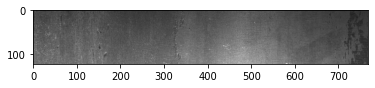

In [11]:
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

def resize_image(im, max_size=768):
    if np.max(im.shape) > max_size:
        ratio = max_size / np.max(im.shape)
        print(f"Resize image to ({str(int(im.shape[1]*ratio))}, {str(int(im.shape[0]*ratio))}).")
        return cv2.resize(im, (0,0), fx=ratio, fy=ratio)
    return im

train_path = 'train_images/'
#train_images = [f for f in listdir(train_path) if isfile(join(train_path,f))]
#print(train_images[0])


testshow = join(train_path, tr.iloc[0]['ImageId'])
print(testshow)

# Test images 
if isfile(testshow):
  im = cv2.imread(testshow)[..., ::-1]
  im = resize_image(im) # Resize image to prevent GPU OOM.
  h, w, _ = im.shape
  plt.imshow(im)    

*** null 확인 ***


ImageId          0
ClassId          0
EncodedPixels    0
dtype: int64

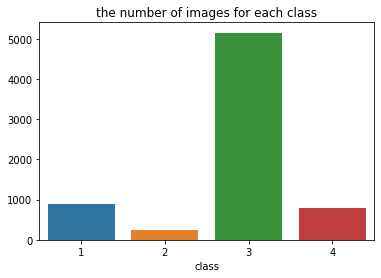

In [12]:
from collections import defaultdict

class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num =0
defects_num = 0

for row in range(0, len(tr)):
  label = tr.iloc[row, 1]
  class_dict[label] += 1
  
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict

print('*** null 확인 ***')
tr.isnull().sum()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


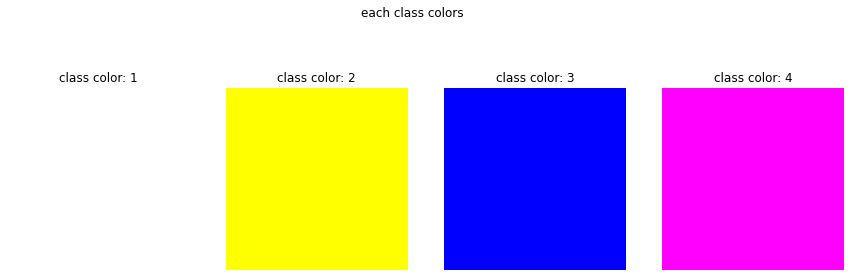

In [31]:
palet = [(255,255,255),(110,170,0),(0,0,241),(114,0,218),(170,0,0)]

fig, ax = plt.subplots(1,4, figsize=(15,5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50,50,3))*palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [0]:
idx_others = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []

for row in range(0, len(tr)):
    labels = tr.iloc[row, 1]
    if (labels == 1):
        idx_class_1.append(row)
    elif (labels == 2):
        idx_class_2.append(row)
    elif (labels == 3):
        idx_class_3.append(row)
    elif (labels == 4):
        idx_class_4.append(row)
    else:
        idx_others.append(row)

In [17]:
names = tr.iloc[0]['ImageId']
print(names)

masks = tr.iloc[0, 2]
masks = list(masks.split(" "))
print(masks)
print(masks[0::2])
positions = map(int, masks[0::2])
print(positions)
positions = masks[0::2]
print(positions)
length = list(map(int, masks[1::2]))
print(length)


#29102 12 29346 24 29602 24 means take 12 pixels starting from 29102, take 2 pixel starting from 29346, take 24 pixels starting from 29602.


0002cc93b.jpg
['29102', '12', '29346', '24', '29602', '24', '29858', '24', '30114', '24', '30370', '24', '30626', '24', '30882', '24', '31139', '23', '31395', '23', '31651', '23', '31907', '23', '32163', '23', '32419', '23', '32675', '23', '77918', '27', '78174', '55', '78429', '60', '78685', '64', '78941', '68', '79197', '72', '79452', '77', '79708', '81', '79964', '85', '80220', '89', '80475', '94', '80731', '98', '80987', '102', '81242', '105', '81498', '105', '81754', '104', '82010', '104', '82265', '105', '82521', '31', '82556', '69', '82779', '27', '82818', '63', '83038', '22', '83080', '57', '83297', '17', '83342', '50', '83555', '13', '83604', '44', '83814', '8', '83866', '37', '84073', '3', '84128', '31', '84390', '25', '84652', '18', '84918', '8', '85239', '10', '85476', '29', '85714', '47', '85960', '57', '86216', '57', '86471', '58', '86727', '58', '86983', '58', '87238', '59', '87494', '59', '87750', '59', '88005', '60', '88261', '60', '88517', '60', '88772', '61', '89028'

In [0]:
def name_and_mask(start_idx):
  col = start_idx
      
  masks = tr.iloc[col, 2]
  masks = list(masks.split(" "))

  mask = np.zeros((256,1600), dtype=np.uint8)
  mask_label = np.zeros(1600*256, dtype=np.uint8)

  positions = list(map(int, masks[0::2]))
  length = list(map(int, masks[1::2]))

  #positions = masks[0::2]
  #length = masks[1::2]


  for pos, le in zip(positions, length):
    mask_label[pos-1:pos+le-1] = 1
  mask[:, :] = mask_label.reshape(256,1600, order='F')

  return tr.iloc[col][0], mask

def show_mask_image(col):
  name, mask = name_and_mask(col)
  print(name)

  img = cv2.imread(train_path + name)
  fig, ax = plt.subplots(figsize=(15,15))

  contours, _ = cv2.findContours(mask[:,:], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  
  for i in range(0, len(contours)):
    cv2.polylines(img, contours[i], True, palet[tr.iloc[col]['ClassId']], 2)

  ax.set_title(name)
  ax.imshow(img)
  plt.show()

for idx in idx_others[:5]:
  show_mask_image(idx)

0002cc93b.jpg


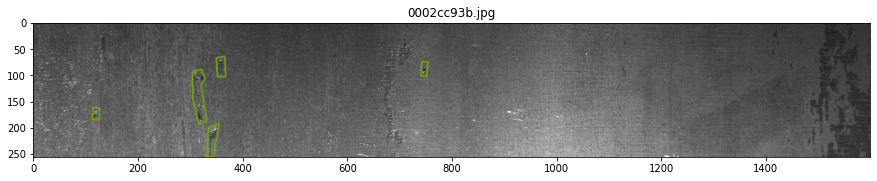

000a4bcdd.jpg


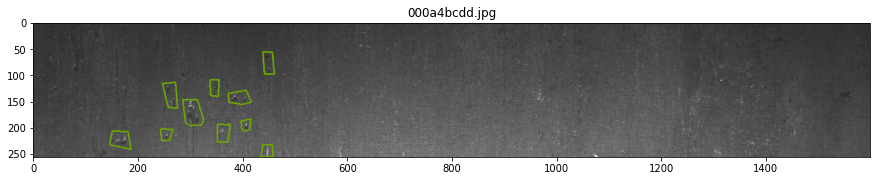

002fc4e19.jpg


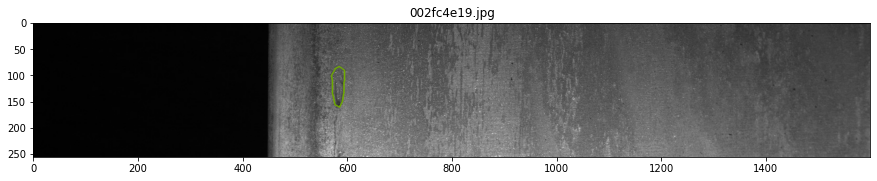

008ef3d74.jpg


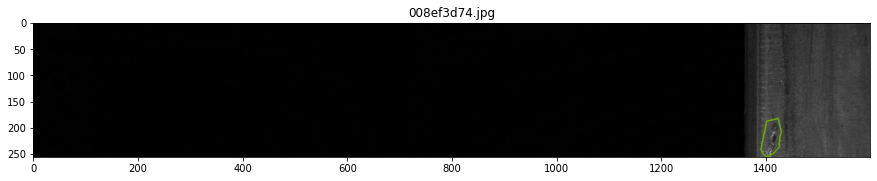

00ac8372f.jpg


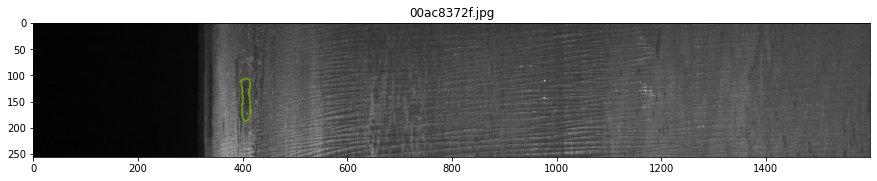

In [32]:
for idx in idx_class_1[:5]:
    show_mask_image(idx)

In [0]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train.head()

#df_val = te[te['EncodedPixels'].notnull()].reset_index(drop=True)

## Runlength encoding for masking

In [0]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

## Data Generator Train

In [0]:
def keras_generator_train(batch_size):
    while True:
        x_batch = []
        img_cls_list = []
        mask_list = []
        classification_list = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread('dataset/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            # print("Shape: ", img.shape)          
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            # img = cv2.resize(img, (image_size, image_size))
            # mask = cv2.resize(mask, (image_size, image_size))

            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
            mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))

            
            # img_cls = df_train['ImageId_ClassId'].iloc[i].split('_')[1]
            # if img_cls == '1':
            #     img_cls_list = np.array([1, 0, 0, 0])
            # elif img_cls == '2':
            #     img_cls_list = np.array([0, 1, 0, 0])
            # elif img_cls == '3':
            #     img_cls_list = np.array([0, 0, 1, 0])
            # else:
            #     img_cls_list = np.array([0, 0, 0, 1])



            x_batch.append(img)
            mask_list.append(mask)
            # classification_list.append(img_cls_list)
        
        y_batch = {'seg': np.array(mask_list),
                #    'cls': np.array(classification_list)
                }
           
        x_batch = np.array(x_batch)

        yield x_batch, y_batch

## Data Generator Valid

In [0]:
def keras_generator_valid(batch_size):
    while True:
        x_batch = []
        img_cls_list = []
        mask_list = []
        classification_list = []
        
        for i in range(batch_size):            
            fn = df_val['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread( 'dataset/valid_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            # img = cv2.resize(img, (image_size, image_size))
            # mask = cv2.resize(mask, (image_size, image_size))

            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

            mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
            
            # img_cls = df_train['ImageId_ClassId'].iloc[i].split('_')[1]
            # if img_cls == '1':
            #     img_cls_list = np.array([1, 0, 0, 0])
            # elif img_cls == '2':
            #     img_cls_list = np.array([0, 1, 0, 0])
            # elif img_cls == '3':
            #     img_cls_list = np.array([0, 0, 1, 0])
            # else:
            #     img_cls_list = np.array([0, 0, 0, 1])
            
            x_batch.append(img)
            mask_list.append(mask)
            # classification_list.append(img_cls_list)
        
        y_batch = {'seg': np.array(mask_list),
                #    'cls': np.array(classification_list)
                }
           
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [0]:
for xcls, ycls in keras_generator_train(5):
    break
    
print(xcls.shape)
print(ycls['seg'].shape)
# print(ycls['cls'].shape)

In [0]:
for xcls, ycls in keras_generator_valid(5):
    break
    
print(xcls.shape)
print(ycls['seg'].shape)
# print(ycls['cls'].shape)

## Model

In [0]:
# in1 = Input(shape=(image_size, image_size, 3 ))

in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(in1)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv5)

In [0]:
model = Model(inputs=[in1], outputs=[segmentation])

## Parameters for compilation of model

In [0]:
losses = {'seg': 'binary_crossentropy'
            }

metrics = {'seg': ['acc']
            }

# cls_w = {'seg': {0: 1.0, 
#                  1: 1.5647207819029325, 
#                  2: 1.0, 
#                  3: 1.0}
#         }

moni = {'seg': ['val_loss']
        }

## Compile

In [0]:
model.compile(optimizer="adam", loss = losses, metrics=metrics)

## Fit Generator

In [0]:
%%time

modelcheckpoint = ModelCheckpoint(model_name,
                                  monitor='acc',
                                  mode='auto',
                                  verbose=1,
                                  save_best_only=True)

lr_callback = ReduceLROnPlateau(min_lr=0.000001)

callback_list = [modelcheckpoint, lr_callback]

history = model.fit_generator(
    keras_generator_train(batch_size),
    validation_data = keras_generator_valid(batch_size),
    validation_steps = 100,
    steps_per_epoch=100,
    epochs=epochs,
    verbose=1, 
    shuffle=True,
    callbacks = callback_list,
    # class_weight = cls_w,
)